In [2]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.VERSION)

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
plt.interactive(False)

from pathlib import *

data_root = Path('/home/charles/Downloads/dataset5/A')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))


1.13.1


Found 12553 images belonging to 24 classes.


In [3]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

import tensorflow_hub as hub
from tensorflow.keras import layers


def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Found 12553 images belonging to 24 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 24)


In [4]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False


In [12]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                30744     
Total params: 30,744
Trainable params: 30,744
Non-trainable params: 0
_________________________________________________________________


In [14]:
init = tf.global_variables_initializer()
sess.run(init)
result = model.predict(image_batch)
result.shape

(32, 24)

In [15]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])


W0309 17:19:47.454568 140647070504448 deprecation.py:323] From /home/charles/TF/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


  1/392 [..............................] - ETA: 11:50 - loss: 3.9427 - acc: 0.0625

  2/392 [..............................] - ETA: 8:53 - loss: 3.6677 - acc: 0.0781 

  3/392 [..............................] - ETA: 7:55 - loss: 3.7067 - acc: 0.0625

  4/392 [..............................] - ETA: 7:38 - loss: 3.7402 - acc: 0.0703

  5/392 [..............................] - ETA: 7:28 - loss: 3.6385 - acc: 0.1000

  6/392 [..............................] - ETA: 7:17 - loss: 3.6838 - acc: 0.0885

  7/392 [..............................] - ETA: 7:07 - loss: 3.6989 - acc: 0.0804

  8/392 [..............................] - ETA: 6:58 - loss: 3.6516 - acc: 0.0820

  9/392 [..............................] - ETA: 6:50 - loss: 3.6085 - acc: 0.0833

 10/392 [..............................] - ETA: 6:43 - loss: 3.5652 - acc: 0.0844

 11/392 [..............................] - ETA: 6:38 - loss: 3.5015 - acc: 0.0852

 12/392 [..............................] - ETA: 6:34 - loss: 3.4343 - acc: 0.0990

 13/392 [..............................] - ETA: 6:33 - loss: 3.3792 - acc: 0.1010

 14/392 [>.............................] - ETA: 6:30 - loss: 3.3398 - acc: 0.1071

 15/392 [>.............................] - ETA: 6:27 - loss: 3.2696 - acc: 0.1333

 16/392 [>.............................] - ETA: 6:24 - loss: 3.2057 - acc: 0.1465

 17/392 [>.............................] - ETA: 6:21 - loss: 3.1469 - acc: 0.1618

 18/392 [>.............................] - ETA: 6:18 - loss: 3.1045 - acc: 0.1719

 19/392 [>.............................] - ETA: 6:14 - loss: 3.0753 - acc: 0.1760

 20/392 [>.............................] - ETA: 6:12 - loss: 3.0233 - acc: 0.1875

 21/392 [>.............................] - ETA: 6:09 - loss: 2.9926 - acc: 0.1935

 22/392 [>.............................] - ETA: 6:07 - loss: 2.9405 - acc: 0.2088

 23/392 [>.............................] - ETA: 6:05 - loss: 2.9075 - acc: 0.2160

 24/392 [>.............................] - ETA: 6:03 - loss: 2.8737 - acc: 0.2201

 25/392 [>.............................] - ETA: 6:01 - loss: 2.8429 - acc: 0.2237

 26/392 [>.............................] - ETA: 5:59 - loss: 2.8280 - acc: 0.2296

 27/392 [=>............................] - ETA: 5:57 - loss: 2.7938 - acc: 0.2373

 28/392 [=>............................] - ETA: 5:55 - loss: 2.7613 - acc: 0.2500

 29/392 [=>............................] - ETA: 5:54 - loss: 2.7378 - acc: 0.2565

 30/392 [=>............................] - ETA: 5:52 - loss: 2.7105 - acc: 0.2646

 31/392 [=>............................] - ETA: 5:50 - loss: 2.6802 - acc: 0.2722

 32/392 [=>............................] - ETA: 5:49 - loss: 2.6401 - acc: 0.2861

 33/392 [=>............................] - ETA: 5:47 - loss: 2.6035 - acc: 0.2973

 34/392 [=>............................] - ETA: 5:46 - loss: 2.5686 - acc: 0.3061

 35/392 [=>............................] - ETA: 5:44 - loss: 2.5471 - acc: 0.3098

 36/392 [=>............................] - ETA: 5:43 - loss: 2.5219 - acc: 0.3177

 37/392 [=>............................] - ETA: 5:41 - loss: 2.4866 - acc: 0.3269

 38/392 [=>............................] - ETA: 5:40 - loss: 2.4587 - acc: 0.3347

 39/392 [=>............................] - ETA: 5:39 - loss: 2.4268 - acc: 0.3454

 40/392 [==>...........................] - ETA: 5:38 - loss: 2.4075 - acc: 0.3484

 41/392 [==>...........................] - ETA: 5:36 - loss: 2.3889 - acc: 0.3506

 42/392 [==>...........................] - ETA: 5:35 - loss: 2.3651 - acc: 0.3579

 43/392 [==>...........................] - ETA: 5:35 - loss: 2.3443 - acc: 0.3641

 44/392 [==>...........................] - ETA: 5:34 - loss: 2.3210 - acc: 0.3714

 45/392 [==>...........................] - ETA: 5:34 - loss: 2.2964 - acc: 0.3771

 46/392 [==>...........................] - ETA: 5:33 - loss: 2.2726 - acc: 0.3852

 47/392 [==>...........................] - ETA: 5:32 - loss: 2.2524 - acc: 0.3910

 48/392 [==>...........................] - ETA: 5:32 - loss: 2.2253 - acc: 0.3997

 49/392 [==>...........................] - ETA: 5:31 - loss: 2.2052 - acc: 0.4062

 50/392 [==>...........................] - ETA: 5:30 - loss: 2.1784 - acc: 0.4137

 51/392 [==>...........................] - ETA: 5:29 - loss: 2.1630 - acc: 0.4191

 52/392 [==>...........................] - ETA: 5:29 - loss: 2.1364 - acc: 0.4267

 53/392 [===>..........................] - ETA: 5:28 - loss: 2.1204 - acc: 0.4328

 54/392 [===>..........................] - ETA: 5:27 - loss: 2.1054 - acc: 0.4375

 55/392 [===>..........................] - ETA: 5:27 - loss: 2.0853 - acc: 0.4437

 56/392 [===>..........................] - ETA: 5:26 - loss: 2.0687 - acc: 0.4481

 57/392 [===>..........................] - ETA: 5:25 - loss: 2.0561 - acc: 0.4518

 58/392 [===>..........................] - ETA: 5:24 - loss: 2.0379 - acc: 0.4574

 59/392 [===>..........................] - ETA: 5:24 - loss: 2.0145 - acc: 0.4645

 60/392 [===>..........................] - ETA: 5:23 - loss: 2.0007 - acc: 0.4698

 61/392 [===>..........................] - ETA: 5:22 - loss: 1.9869 - acc: 0.4744

 62/392 [===>..........................] - ETA: 5:21 - loss: 1.9680 - acc: 0.4798

 63/392 [===>..........................] - ETA: 5:20 - loss: 1.9520 - acc: 0.4841

 64/392 [===>..........................] - ETA: 5:19 - loss: 1.9386 - acc: 0.4873

 65/392 [===>..........................] - ETA: 5:18 - loss: 1.9263 - acc: 0.4889

 66/392 [====>.........................] - ETA: 5:17 - loss: 1.9133 - acc: 0.4920

 67/392 [====>.........................] - ETA: 5:16 - loss: 1.8962 - acc: 0.4967

 68/392 [====>.........................] - ETA: 5:16 - loss: 1.8818 - acc: 0.5009

 69/392 [====>.........................] - ETA: 5:15 - loss: 1.8663 - acc: 0.5054

 70/392 [====>.........................] - ETA: 5:14 - loss: 1.8539 - acc: 0.5094

 71/392 [====>.........................] - ETA: 5:13 - loss: 1.8439 - acc: 0.5106

 72/392 [====>.........................] - ETA: 5:12 - loss: 1.8314 - acc: 0.5148

 73/392 [====>.........................] - ETA: 5:11 - loss: 1.8183 - acc: 0.5193

 74/392 [====>.........................] - ETA: 5:10 - loss: 1.8059 - acc: 0.5220

 75/392 [====>.........................] - ETA: 5:09 - loss: 1.7923 - acc: 0.5263

 76/392 [====>.........................] - ETA: 5:09 - loss: 1.7783 - acc: 0.5304

 77/392 [====>.........................] - ETA: 5:08 - loss: 1.7647 - acc: 0.5345

 78/392 [====>.........................] - ETA: 5:08 - loss: 1.7547 - acc: 0.5381

 79/392 [=====>........................] - ETA: 5:07 - loss: 1.7437 - acc: 0.5407

 80/392 [=====>........................] - ETA: 5:06 - loss: 1.7321 - acc: 0.5445

 81/392 [=====>........................] - ETA: 5:05 - loss: 1.7249 - acc: 0.5459

 82/392 [=====>........................] - ETA: 5:04 - loss: 1.7168 - acc: 0.5476

 83/392 [=====>........................] - ETA: 5:03 - loss: 1.7056 - acc: 0.5508

 84/392 [=====>........................] - ETA: 5:02 - loss: 1.6936 - acc: 0.5532

 85/392 [=====>........................] - ETA: 5:01 - loss: 1.6821 - acc: 0.5562

 86/392 [=====>........................] - ETA: 5:00 - loss: 1.6712 - acc: 0.5596

 87/392 [=====>........................] - ETA: 4:59 - loss: 1.6638 - acc: 0.5618

 88/392 [=====>........................] - ETA: 4:58 - loss: 1.6562 - acc: 0.5636

 89/392 [=====>........................] - ETA: 4:57 - loss: 1.6469 - acc: 0.5667

 90/392 [=====>........................] - ETA: 4:56 - loss: 1.6361 - acc: 0.5694

 91/392 [=====>........................] - ETA: 4:56 - loss: 1.6239 - acc: 0.5728

 92/392 [======>.......................] - ETA: 4:55 - loss: 1.6132 - acc: 0.5761

 93/392 [======>.......................] - ETA: 4:54 - loss: 1.6041 - acc: 0.5780

 94/392 [======>.......................] - ETA: 4:53 - loss: 1.5939 - acc: 0.5818

 95/392 [======>.......................] - ETA: 4:52 - loss: 1.5842 - acc: 0.5859

 96/392 [======>.......................] - ETA: 4:51 - loss: 1.5753 - acc: 0.5882

 97/392 [======>.......................] - ETA: 4:50 - loss: 1.5699 - acc: 0.5896

 98/392 [======>.......................] - ETA: 4:49 - loss: 1.5626 - acc: 0.5915

 99/392 [======>.......................] - ETA: 4:48 - loss: 1.5523 - acc: 0.5944

100/392 [======>.......................] - ETA: 4:47 - loss: 1.5432 - acc: 0.5969

101/392 [======>.......................] - ETA: 4:46 - loss: 1.5336 - acc: 0.5996

102/392 [======>.......................] - ETA: 4:45 - loss: 1.5268 - acc: 0.6020

103/392 [======>.......................] - ETA: 4:44 - loss: 1.5185 - acc: 0.6035

104/392 [======>.......................] - ETA: 4:43 - loss: 1.5109 - acc: 0.6055

105/392 [=======>......................] - ETA: 4:42 - loss: 1.5019 - acc: 0.6083

106/392 [=======>......................] - ETA: 4:41 - loss: 1.4948 - acc: 0.6106

107/392 [=======>......................] - ETA: 4:40 - loss: 1.4888 - acc: 0.6121

108/392 [=======>......................] - ETA: 4:39 - loss: 1.4799 - acc: 0.6152

109/392 [=======>......................] - ETA: 4:38 - loss: 1.4737 - acc: 0.6173

110/392 [=======>......................] - ETA: 4:37 - loss: 1.4640 - acc: 0.6199

111/392 [=======>......................] - ETA: 4:36 - loss: 1.4560 - acc: 0.6227

112/392 [=======>......................] - ETA: 4:35 - loss: 1.4471 - acc: 0.6253

113/392 [=======>......................] - ETA: 4:34 - loss: 1.4414 - acc: 0.6267

114/392 [=======>......................] - ETA: 4:34 - loss: 1.4340 - acc: 0.6286

115/392 [=======>......................] - ETA: 4:33 - loss: 1.4254 - acc: 0.6310

116/392 [=======>......................] - ETA: 4:32 - loss: 1.4195 - acc: 0.6331

117/392 [=======>......................] - ETA: 4:31 - loss: 1.4133 - acc: 0.6354

118/392 [========>.....................] - ETA: 4:30 - loss: 1.4065 - acc: 0.6367

119/392 [========>.....................] - ETA: 4:29 - loss: 1.4014 - acc: 0.6381

120/392 [========>.....................] - ETA: 4:28 - loss: 1.3976 - acc: 0.6396

121/392 [========>.....................] - ETA: 4:27 - loss: 1.3910 - acc: 0.6415

122/392 [========>.....................] - ETA: 4:26 - loss: 1.3855 - acc: 0.6427

123/392 [========>.....................] - ETA: 4:25 - loss: 1.3797 - acc: 0.6441

124/392 [========>.....................] - ETA: 4:24 - loss: 1.3734 - acc: 0.6462

125/392 [========>.....................] - ETA: 4:23 - loss: 1.3685 - acc: 0.6472

126/392 [========>.....................] - ETA: 4:22 - loss: 1.3619 - acc: 0.6488

127/392 [========>.....................] - ETA: 4:21 - loss: 1.3558 - acc: 0.6506

128/392 [========>.....................] - ETA: 4:20 - loss: 1.3511 - acc: 0.6514

129/392 [========>.....................] - ETA: 4:19 - loss: 1.3458 - acc: 0.6529

130/392 [========>.....................] - ETA: 4:18 - loss: 1.3414 - acc: 0.6538

131/392 [=========>....................] - ETA: 4:17 - loss: 1.3362 - acc: 0.6548

132/392 [=========>....................] - ETA: 4:16 - loss: 1.3299 - acc: 0.6572

133/392 [=========>....................] - ETA: 4:15 - loss: 1.3243 - acc: 0.6588

134/392 [=========>....................] - ETA: 4:14 - loss: 1.3186 - acc: 0.6600

135/392 [=========>....................] - ETA: 4:13 - loss: 1.3144 - acc: 0.6611

136/392 [=========>....................] - ETA: 4:13 - loss: 1.3095 - acc: 0.6629

137/392 [=========>....................] - ETA: 4:12 - loss: 1.3042 - acc: 0.6645

138/392 [=========>....................] - ETA: 4:11 - loss: 1.2982 - acc: 0.6660

139/392 [=========>....................] - ETA: 4:10 - loss: 1.2920 - acc: 0.6677

140/392 [=========>....................] - ETA: 4:09 - loss: 1.2855 - acc: 0.6694

141/392 [=========>....................] - ETA: 4:08 - loss: 1.2782 - acc: 0.6718

142/392 [=========>....................] - ETA: 4:07 - loss: 1.2721 - acc: 0.6736

143/392 [=========>....................] - ETA: 4:06 - loss: 1.2664 - acc: 0.6748

144/392 [==========>...................] - ETA: 4:05 - loss: 1.2607 - acc: 0.6766

145/392 [==========>...................] - ETA: 4:04 - loss: 1.2552 - acc: 0.6784

146/392 [==========>...................] - ETA: 4:03 - loss: 1.2510 - acc: 0.6800

147/392 [==========>...................] - ETA: 4:02 - loss: 1.2459 - acc: 0.6813

148/392 [==========>...................] - ETA: 4:01 - loss: 1.2412 - acc: 0.6829

149/392 [==========>...................] - ETA: 4:00 - loss: 1.2360 - acc: 0.6841

150/392 [==========>...................] - ETA: 3:59 - loss: 1.2306 - acc: 0.6856

151/392 [==========>...................] - ETA: 3:58 - loss: 1.2271 - acc: 0.6865

152/392 [==========>...................] - ETA: 3:57 - loss: 1.2239 - acc: 0.6877

153/392 [==========>...................] - ETA: 3:56 - loss: 1.2188 - acc: 0.6893

154/392 [==========>...................] - ETA: 3:55 - loss: 1.2136 - acc: 0.6907

155/392 [==========>...................] - ETA: 3:54 - loss: 1.2094 - acc: 0.6921

156/392 [==========>...................] - ETA: 3:53 - loss: 1.2061 - acc: 0.6931

157/392 [===========>..................] - ETA: 3:52 - loss: 1.2013 - acc: 0.6945

158/392 [===========>..................] - ETA: 3:51 - loss: 1.1959 - acc: 0.6962

159/392 [===========>..................] - ETA: 3:50 - loss: 1.1912 - acc: 0.6975

160/392 [===========>..................] - ETA: 3:49 - loss: 1.1859 - acc: 0.6990

161/392 [===========>..................] - ETA: 3:48 - loss: 1.1807 - acc: 0.7003

162/392 [===========>..................] - ETA: 3:47 - loss: 1.1759 - acc: 0.7018

163/392 [===========>..................] - ETA: 3:46 - loss: 1.1725 - acc: 0.7023

164/392 [===========>..................] - ETA: 3:45 - loss: 1.1684 - acc: 0.7035

165/392 [===========>..................] - ETA: 3:44 - loss: 1.1644 - acc: 0.7049

166/392 [===========>..................] - ETA: 3:43 - loss: 1.1589 - acc: 0.7063

167/392 [===========>..................] - ETA: 3:42 - loss: 1.1544 - acc: 0.7077

168/392 [===========>..................] - ETA: 3:42 - loss: 1.1498 - acc: 0.7091

169/392 [===========>..................] - ETA: 3:41 - loss: 1.1442 - acc: 0.7108

170/392 [============>.................] - ETA: 3:40 - loss: 1.1411 - acc: 0.7116

171/392 [============>.................] - ETA: 3:39 - loss: 1.1365 - acc: 0.7124

172/392 [============>.................] - ETA: 3:38 - loss: 1.1330 - acc: 0.7135

173/392 [============>.................] - ETA: 3:37 - loss: 1.1291 - acc: 0.7144

174/392 [============>.................] - ETA: 3:36 - loss: 1.1263 - acc: 0.7152

175/392 [============>.................] - ETA: 3:35 - loss: 1.1238 - acc: 0.7155

176/392 [============>.................] - ETA: 3:34 - loss: 1.1203 - acc: 0.7166

177/392 [============>.................] - ETA: 3:33 - loss: 1.1159 - acc: 0.7179

178/392 [============>.................] - ETA: 3:32 - loss: 1.1128 - acc: 0.7188

179/392 [============>.................] - ETA: 3:31 - loss: 1.1092 - acc: 0.7203

180/392 [============>.................] - ETA: 3:30 - loss: 1.1066 - acc: 0.7210

181/392 [============>.................] - ETA: 3:29 - loss: 1.1043 - acc: 0.7215

182/392 [============>.................] - ETA: 3:28 - loss: 1.1010 - acc: 0.7220

183/392 [=============>................] - ETA: 3:27 - loss: 1.0979 - acc: 0.7228

184/392 [=============>................] - ETA: 3:26 - loss: 1.0942 - acc: 0.7240

185/392 [=============>................] - ETA: 3:25 - loss: 1.0898 - acc: 0.7255

186/392 [=============>................] - ETA: 3:24 - loss: 1.0866 - acc: 0.7261

187/392 [=============>................] - ETA: 3:23 - loss: 1.0832 - acc: 0.7269

188/392 [=============>................] - ETA: 3:22 - loss: 1.0803 - acc: 0.7276

189/392 [=============>................] - ETA: 3:21 - loss: 1.0767 - acc: 0.7283

190/392 [=============>................] - ETA: 3:20 - loss: 1.0736 - acc: 0.7291

191/392 [=============>................] - ETA: 3:19 - loss: 1.0699 - acc: 0.7300

192/392 [=============>................] - ETA: 3:18 - loss: 1.0660 - acc: 0.7311

193/392 [=============>................] - ETA: 3:17 - loss: 1.0631 - acc: 0.7320

194/392 [=============>................] - ETA: 3:16 - loss: 1.0606 - acc: 0.7328

195/392 [=============>................] - ETA: 3:15 - loss: 1.0571 - acc: 0.7337

196/392 [==============>...............] - ETA: 3:14 - loss: 1.0541 - acc: 0.7344

197/392 [==============>...............] - ETA: 3:13 - loss: 1.0503 - acc: 0.7354

198/392 [==============>...............] - ETA: 3:12 - loss: 1.0464 - acc: 0.7367

199/392 [==============>...............] - ETA: 3:11 - loss: 1.0425 - acc: 0.7378

200/392 [==============>...............] - ETA: 3:10 - loss: 1.0392 - acc: 0.7386

201/392 [==============>...............] - ETA: 3:09 - loss: 1.0354 - acc: 0.7396

202/392 [==============>...............] - ETA: 3:08 - loss: 1.0323 - acc: 0.7403

203/392 [==============>...............] - ETA: 3:07 - loss: 1.0286 - acc: 0.7412

204/392 [==============>...............] - ETA: 3:06 - loss: 1.0253 - acc: 0.7420

205/392 [==============>...............] - ETA: 3:05 - loss: 1.0215 - acc: 0.7431

206/392 [==============>...............] - ETA: 3:04 - loss: 1.0185 - acc: 0.7441

207/392 [==============>...............] - ETA: 3:03 - loss: 1.0151 - acc: 0.7453

208/392 [==============>...............] - ETA: 3:02 - loss: 1.0126 - acc: 0.7458

209/392 [==============>...............] - ETA: 3:01 - loss: 1.0095 - acc: 0.7469

210/392 [===============>..............] - ETA: 3:00 - loss: 1.0070 - acc: 0.7476

211/392 [===============>..............] - ETA: 2:59 - loss: 1.0037 - acc: 0.7485

212/392 [===============>..............] - ETA: 2:58 - loss: 1.0004 - acc: 0.7493

213/392 [===============>..............] - ETA: 2:57 - loss: 0.9987 - acc: 0.7493

214/392 [===============>..............] - ETA: 2:56 - loss: 0.9968 - acc: 0.7497

215/392 [===============>..............] - ETA: 2:55 - loss: 0.9941 - acc: 0.7504

216/392 [===============>..............] - ETA: 2:54 - loss: 0.9914 - acc: 0.7512

217/392 [===============>..............] - ETA: 2:53 - loss: 0.9891 - acc: 0.7519

218/392 [===============>..............] - ETA: 2:52 - loss: 0.9864 - acc: 0.7526

219/392 [===============>..............] - ETA: 2:51 - loss: 0.9837 - acc: 0.7533

220/392 [===============>..............] - ETA: 2:50 - loss: 0.9806 - acc: 0.7543

221/392 [===============>..............] - ETA: 2:49 - loss: 0.9781 - acc: 0.7549

222/392 [===============>..............] - ETA: 2:48 - loss: 0.9766 - acc: 0.7555

223/392 [================>.............] - ETA: 2:47 - loss: 0.9748 - acc: 0.7562

224/392 [================>.............] - ETA: 2:46 - loss: 0.9715 - acc: 0.7571

225/392 [================>.............] - ETA: 2:45 - loss: 0.9683 - acc: 0.7581

226/392 [================>.............] - ETA: 2:44 - loss: 0.9650 - acc: 0.7591

227/392 [================>.............] - ETA: 2:43 - loss: 0.9615 - acc: 0.7602

228/392 [================>.............] - ETA: 2:42 - loss: 0.9585 - acc: 0.7612

229/392 [================>.............] - ETA: 2:41 - loss: 0.9553 - acc: 0.7623

230/392 [================>.............] - ETA: 2:40 - loss: 0.9531 - acc: 0.7628

231/392 [================>.............] - ETA: 2:39 - loss: 0.9508 - acc: 0.7631

232/392 [================>.............] - ETA: 2:38 - loss: 0.9483 - acc: 0.7637

233/392 [================>.............] - ETA: 2:37 - loss: 0.9459 - acc: 0.7644

234/392 [================>.............] - ETA: 2:36 - loss: 0.9432 - acc: 0.7652

235/392 [================>.............] - ETA: 2:35 - loss: 0.9403 - acc: 0.7660

236/392 [=================>............] - ETA: 2:34 - loss: 0.9372 - acc: 0.7668

237/392 [=================>............] - ETA: 2:33 - loss: 0.9345 - acc: 0.7675

238/392 [=================>............] - ETA: 2:32 - loss: 0.9325 - acc: 0.7681

239/392 [=================>............] - ETA: 2:31 - loss: 0.9301 - acc: 0.7687

240/392 [=================>............] - ETA: 2:30 - loss: 0.9276 - acc: 0.7693

241/392 [=================>............] - ETA: 2:29 - loss: 0.9246 - acc: 0.7701

242/392 [=================>............] - ETA: 2:29 - loss: 0.9227 - acc: 0.7707

243/392 [=================>............] - ETA: 2:28 - loss: 0.9212 - acc: 0.7708

244/392 [=================>............] - ETA: 2:27 - loss: 0.9194 - acc: 0.7713

245/392 [=================>............] - ETA: 2:26 - loss: 0.9166 - acc: 0.7719

246/392 [=================>............] - ETA: 2:25 - loss: 0.9144 - acc: 0.7726

247/392 [=================>............] - ETA: 2:24 - loss: 0.9126 - acc: 0.7729

248/392 [=================>............] - ETA: 2:23 - loss: 0.9105 - acc: 0.7733

249/392 [==================>...........] - ETA: 2:22 - loss: 0.9090 - acc: 0.7736

250/392 [==================>...........] - ETA: 2:21 - loss: 0.9066 - acc: 0.7742

251/392 [==================>...........] - ETA: 2:20 - loss: 0.9044 - acc: 0.7748

252/392 [==================>...........] - ETA: 2:19 - loss: 0.9024 - acc: 0.7754

253/392 [==================>...........] - ETA: 2:18 - loss: 0.8997 - acc: 0.7761

254/392 [==================>...........] - ETA: 2:17 - loss: 0.8981 - acc: 0.7766

255/392 [==================>...........] - ETA: 2:16 - loss: 0.8962 - acc: 0.7770

256/392 [==================>...........] - ETA: 2:15 - loss: 0.8941 - acc: 0.7776

257/392 [==================>...........] - ETA: 2:14 - loss: 0.8923 - acc: 0.7778

258/392 [==================>...........] - ETA: 2:13 - loss: 0.8898 - acc: 0.7785

259/392 [==================>...........] - ETA: 2:12 - loss: 0.8873 - acc: 0.7791

260/392 [==================>...........] - ETA: 2:11 - loss: 0.8852 - acc: 0.7796

261/392 [==================>...........] - ETA: 2:10 - loss: 0.8837 - acc: 0.7797

262/392 [===================>..........] - ETA: 2:09 - loss: 0.8810 - acc: 0.7804

263/392 [===================>..........] - ETA: 2:08 - loss: 0.8790 - acc: 0.7809

264/392 [===================>..........] - ETA: 2:07 - loss: 0.8772 - acc: 0.7815

265/392 [===================>..........] - ETA: 2:06 - loss: 0.8753 - acc: 0.7821

266/392 [===================>..........] - ETA: 2:05 - loss: 0.8733 - acc: 0.7828

267/392 [===================>..........] - ETA: 2:04 - loss: 0.8719 - acc: 0.7832

268/392 [===================>..........] - ETA: 2:03 - loss: 0.8700 - acc: 0.7838

269/392 [===================>..........] - ETA: 2:02 - loss: 0.8678 - acc: 0.7843

270/392 [===================>..........] - ETA: 2:01 - loss: 0.8660 - acc: 0.7847

271/392 [===================>..........] - ETA: 2:00 - loss: 0.8643 - acc: 0.7851

272/392 [===================>..........] - ETA: 1:59 - loss: 0.8616 - acc: 0.7858

273/392 [===================>..........] - ETA: 1:58 - loss: 0.8595 - acc: 0.7865

274/392 [===================>..........] - ETA: 1:57 - loss: 0.8571 - acc: 0.7872

275/392 [====================>.........] - ETA: 1:56 - loss: 0.8549 - acc: 0.7878

276/392 [====================>.........] - ETA: 1:55 - loss: 0.8528 - acc: 0.7885

277/392 [====================>.........] - ETA: 1:54 - loss: 0.8501 - acc: 0.7893

278/392 [====================>.........] - ETA: 1:53 - loss: 0.8481 - acc: 0.7898

279/392 [====================>.........] - ETA: 1:52 - loss: 0.8461 - acc: 0.7902

280/392 [====================>.........] - ETA: 1:51 - loss: 0.8440 - acc: 0.7908

281/392 [====================>.........] - ETA: 1:50 - loss: 0.8417 - acc: 0.7915

282/392 [====================>.........] - ETA: 1:49 - loss: 0.8399 - acc: 0.7919

283/392 [====================>.........] - ETA: 1:48 - loss: 0.8382 - acc: 0.7923

284/392 [====================>.........] - ETA: 1:47 - loss: 0.8368 - acc: 0.7927

285/392 [====================>.........] - ETA: 1:46 - loss: 0.8351 - acc: 0.7932

286/392 [====================>.........] - ETA: 1:45 - loss: 0.8338 - acc: 0.7934

287/392 [====================>.........] - ETA: 1:44 - loss: 0.8323 - acc: 0.7937

288/392 [=====================>........] - ETA: 1:43 - loss: 0.8304 - acc: 0.7942

289/392 [=====================>........] - ETA: 1:42 - loss: 0.8284 - acc: 0.7947

290/392 [=====================>........] - ETA: 1:41 - loss: 0.8266 - acc: 0.7952

291/392 [=====================>........] - ETA: 1:40 - loss: 0.8246 - acc: 0.7955

292/392 [=====================>........] - ETA: 1:39 - loss: 0.8225 - acc: 0.7961

293/392 [=====================>........] - ETA: 1:38 - loss: 0.8203 - acc: 0.7967

294/392 [=====================>........] - ETA: 1:37 - loss: 0.8184 - acc: 0.7973

295/392 [=====================>........] - ETA: 1:36 - loss: 0.8169 - acc: 0.7977

296/392 [=====================>........] - ETA: 1:35 - loss: 0.8151 - acc: 0.7981

297/392 [=====================>........] - ETA: 1:34 - loss: 0.8135 - acc: 0.7986

298/392 [=====================>........] - ETA: 1:33 - loss: 0.8115 - acc: 0.7993

299/392 [=====================>........] - ETA: 1:32 - loss: 0.8098 - acc: 0.7999

300/392 [=====================>........] - ETA: 1:31 - loss: 0.8084 - acc: 0.8000

301/392 [======================>.......] - ETA: 1:30 - loss: 0.8068 - acc: 0.8004

302/392 [======================>.......] - ETA: 1:29 - loss: 0.8051 - acc: 0.8008

303/392 [======================>.......] - ETA: 1:28 - loss: 0.8033 - acc: 0.8014

304/392 [======================>.......] - ETA: 1:27 - loss: 0.8017 - acc: 0.8018

305/392 [======================>.......] - ETA: 1:26 - loss: 0.8004 - acc: 0.8023

306/392 [======================>.......] - ETA: 1:25 - loss: 0.7993 - acc: 0.8024

307/392 [======================>.......] - ETA: 1:24 - loss: 0.7980 - acc: 0.8026

308/392 [======================>.......] - ETA: 1:23 - loss: 0.7962 - acc: 0.8031

309/392 [======================>.......] - ETA: 1:22 - loss: 0.7947 - acc: 0.8035

310/392 [======================>.......] - ETA: 1:21 - loss: 0.7930 - acc: 0.8040

311/392 [======================>.......] - ETA: 1:20 - loss: 0.7912 - acc: 0.8047

312/392 [======================>.......] - ETA: 1:19 - loss: 0.7895 - acc: 0.8052

313/392 [======================>.......] - ETA: 1:18 - loss: 0.7877 - acc: 0.8057

314/392 [=======================>......] - ETA: 1:17 - loss: 0.7860 - acc: 0.8061

315/392 [=======================>......] - ETA: 1:16 - loss: 0.7847 - acc: 0.8063

316/392 [=======================>......] - ETA: 1:15 - loss: 0.7833 - acc: 0.8067

317/392 [=======================>......] - ETA: 1:14 - loss: 0.7816 - acc: 0.8072

318/392 [=======================>......] - ETA: 1:13 - loss: 0.7808 - acc: 0.8075

319/392 [=======================>......] - ETA: 1:12 - loss: 0.7793 - acc: 0.8079

320/392 [=======================>......] - ETA: 1:12 - loss: 0.7785 - acc: 0.8081

321/392 [=======================>......] - ETA: 1:11 - loss: 0.7777 - acc: 0.8083

322/392 [=======================>......] - ETA: 1:10 - loss: 0.7760 - acc: 0.8087

323/392 [=======================>......] - ETA: 1:09 - loss: 0.7741 - acc: 0.8092

324/392 [=======================>......] - ETA: 1:08 - loss: 0.7727 - acc: 0.8097

325/392 [=======================>......] - ETA: 1:07 - loss: 0.7717 - acc: 0.8099

326/392 [=======================>......] - ETA: 1:06 - loss: 0.7697 - acc: 0.8105

327/392 [========================>.....] - ETA: 1:05 - loss: 0.7684 - acc: 0.8109

328/392 [========================>.....] - ETA: 1:04 - loss: 0.7665 - acc: 0.8115

329/392 [========================>.....] - ETA: 1:03 - loss: 0.7653 - acc: 0.8117

330/392 [========================>.....] - ETA: 1:02 - loss: 0.7637 - acc: 0.8122

331/392 [========================>.....] - ETA: 1:01 - loss: 0.7622 - acc: 0.8126

332/392 [========================>.....] - ETA: 1:00 - loss: 0.7606 - acc: 0.8131

333/392 [========================>.....] - ETA: 59s - loss: 0.7590 - acc: 0.8135 

334/392 [========================>.....] - ETA: 58s - loss: 0.7577 - acc: 0.8139

335/392 [========================>.....] - ETA: 57s - loss: 0.7560 - acc: 0.8144

336/392 [========================>.....] - ETA: 56s - loss: 0.7545 - acc: 0.8146

337/392 [========================>.....] - ETA: 55s - loss: 0.7526 - acc: 0.8152

338/392 [========================>.....] - ETA: 54s - loss: 0.7510 - acc: 0.8156

339/392 [========================>.....] - ETA: 53s - loss: 0.7494 - acc: 0.8160

340/392 [=========================>....] - ETA: 52s - loss: 0.7480 - acc: 0.8164

341/392 [=========================>....] - ETA: 51s - loss: 0.7465 - acc: 0.8169

342/392 [=========================>....] - ETA: 50s - loss: 0.7447 - acc: 0.8174

343/392 [=========================>....] - ETA: 49s - loss: 0.7436 - acc: 0.8177

344/392 [=========================>....] - ETA: 48s - loss: 0.7426 - acc: 0.8178

345/392 [=========================>....] - ETA: 47s - loss: 0.7409 - acc: 0.8182

346/392 [=========================>....] - ETA: 46s - loss: 0.7395 - acc: 0.8186

347/392 [=========================>....] - ETA: 45s - loss: 0.7383 - acc: 0.8184

348/392 [=========================>....] - ETA: 44s - loss: 0.7368 - acc: 0.8190

349/392 [=========================>....] - ETA: 43s - loss: 0.7353 - acc: 0.8194

350/392 [=========================>....] - ETA: 42s - loss: 0.7338 - acc: 0.8199

351/392 [=========================>....] - ETA: 41s - loss: 0.7324 - acc: 0.8202

352/392 [=========================>....] - ETA: 40s - loss: 0.7308 - acc: 0.8208

353/392 [==========================>...] - ETA: 39s - loss: 0.7297 - acc: 0.8211

354/392 [==========================>...] - ETA: 38s - loss: 0.7283 - acc: 0.8215

355/392 [==========================>...] - ETA: 37s - loss: 0.7267 - acc: 0.8219

356/392 [==========================>...] - ETA: 36s - loss: 0.7260 - acc: 0.8221

357/392 [==========================>...] - ETA: 35s - loss: 0.7246 - acc: 0.8224

358/392 [==========================>...] - ETA: 34s - loss: 0.7231 - acc: 0.8228

359/392 [==========================>...] - ETA: 33s - loss: 0.7223 - acc: 0.8229

360/392 [==========================>...] - ETA: 32s - loss: 0.7209 - acc: 0.8233

361/392 [==========================>...] - ETA: 31s - loss: 0.7196 - acc: 0.8237

362/392 [==========================>...] - ETA: 30s - loss: 0.7181 - acc: 0.8241

363/392 [==========================>...] - ETA: 29s - loss: 0.7165 - acc: 0.8246

364/392 [==========================>...] - ETA: 28s - loss: 0.7148 - acc: 0.8249

365/392 [==========================>...] - ETA: 27s - loss: 0.7132 - acc: 0.8253

366/392 [===========================>..] - ETA: 26s - loss: 0.7118 - acc: 0.8258

367/392 [===========================>..] - ETA: 25s - loss: 0.7105 - acc: 0.8260

368/392 [===========================>..] - ETA: 24s - loss: 0.7091 - acc: 0.8264

369/392 [===========================>..] - ETA: 23s - loss: 0.7080 - acc: 0.8266

370/392 [===========================>..] - ETA: 22s - loss: 0.7069 - acc: 0.8268

371/392 [===========================>..] - ETA: 21s - loss: 0.7054 - acc: 0.8272

372/392 [===========================>..] - ETA: 20s - loss: 0.7042 - acc: 0.8277

373/392 [===========================>..] - ETA: 19s - loss: 0.7034 - acc: 0.8280

374/392 [===========================>..] - ETA: 18s - loss: 0.7020 - acc: 0.8285

375/392 [===========================>..] - ETA: 17s - loss: 0.7005 - acc: 0.8288

376/392 [===========================>..] - ETA: 16s - loss: 0.6996 - acc: 0.8290

377/392 [===========================>..] - ETA: 15s - loss: 0.6991 - acc: 0.8291

378/392 [===========================>..] - ETA: 14s - loss: 0.6977 - acc: 0.8294

379/392 [============================>.] - ETA: 13s - loss: 0.6969 - acc: 0.8297

380/392 [============================>.] - ETA: 12s - loss: 0.6956 - acc: 0.8300

381/392 [============================>.] - ETA: 11s - loss: 0.6946 - acc: 0.8302

382/392 [============================>.] - ETA: 10s - loss: 0.6934 - acc: 0.8304

383/392 [============================>.] - ETA: 9s - loss: 0.6919 - acc: 0.8309 

384/392 [============================>.] - ETA: 8s - loss: 0.6908 - acc: 0.8311

385/392 [============================>.] - ETA: 7s - loss: 0.6896 - acc: 0.8313

386/392 [============================>.] - ETA: 6s - loss: 0.6882 - acc: 0.8317

387/392 [============================>.] - ETA: 5s - loss: 0.6869 - acc: 0.8320

388/392 [============================>.] - ETA: 4s - loss: 0.6859 - acc: 0.8323

389/392 [============================>.] - ETA: 3s - loss: 0.6850 - acc: 0.8325

390/392 [============================>.] - ETA: 2s - loss: 0.6840 - acc: 0.8328

391/392 [============================>.] - ETA: 1s - loss: 0.6827 - acc: 0.8331

392/392 [==============================] - 392s 1s/step - loss: 0.6814 - acc: 0.8332


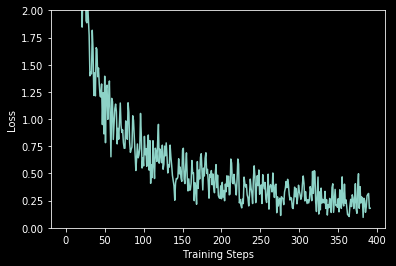

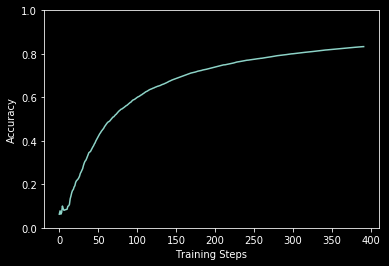

In [30]:
import matplotlib.pylab as plt
plt.style.use('dark_background')

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)


In [20]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'], dtype='<U1')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



W0309 17:34:45.129027 140647070504448 deprecation.py:323] From /home/charles/TF/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:1436: update_checkpoint_state (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


W0309 17:34:49.282811 140647070504448 deprecation.py:323] From /home/charles/TF/venv/lib/python3.7/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:257: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W0309 17:34:49.284032 140647070504448 tf_logging.py:161] Export includes no default signature!


W0309 17:34:54.960933 140647070504448 tf_logging.py:161] Export includes no default signature!


b'./saved_models/1552170882'

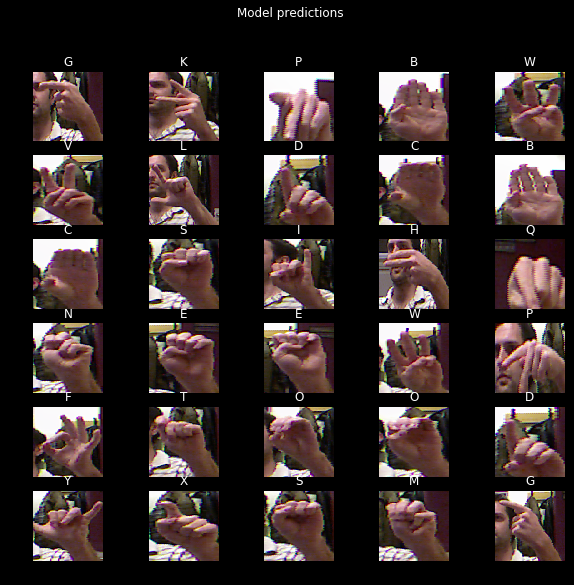

In [32]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]


plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path